```markdown
# Quantum Machine Learning with MNIST Dataset

This notebook demonstrates the application of Quantum Machine Learning (QML) techniques to the MNIST dataset. We focus on classifying the digits '1' and '3' using a hybrid classical-quantum approach.

## Data Preparation

We start by fetching the MNIST dataset and filtering it to include only the digits '1' and '3'. The labels are then converted to binary values: '1' is mapped to 0 and '3' is mapped to 1.

## Principal Component Analysis (PCA)

To reduce the dimensionality of the dataset, we apply PCA. The number of components is chosen to retain 70% of the variance in the data.

- **Number of components to retain 70% variance:** 17

## Data Scaling

The reduced dataset is split into training and testing sets. The training set is then scaled using `StandardScaler`.

## Quantum Kernel

A quantum kernel is defined using the `pennylane` library. The kernel function computes the inner product of quantum states.

## Model Training

### Classical SVM

A classical Support Vector Machine (SVM) is trained on a sampled subset of the training data.

- **Accuracy of SVM:** 0.9760319573901465

### Quantum SVM

A quantum SVM is trained using the quantum kernel. The hyperparameters are optimized using `RandomizedSearchCV`.

- **Best Parameters:** {'random_state': 42, 'probability': False, 'kernel': <function kernel_mat at 0x0000023B706E90D0>, 'gamma': 7.1, 'C': 7.3}
- **Accuracy of QML SVM:** 0.5033288948069241

## Conclusion

The classical SVM outperforms the quantum SVM in this experiment. Further optimization and experimentation with different quantum kernels and larger datasets may improve the performance of the quantum approach.
```

In [ ]:
# importing libraries
import pennylane as qml
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# importing dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# filtering dataset
X_filtered = X[(y == '1') | (y == '3')]
y_filtered = y[(y == '1') | (y == '3')]

# mapping labels to 0 and 1
y_filtered = np.where((y_filtered == '1'), 0, 1)

In [ ]:
pca = PCA()
pca.fit(X_filtered)

# splitting dataset
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.70) + 1 

print(f"Number of components to retain 70% variance: {n_components}")

Number of components to retain 70% variance: 17


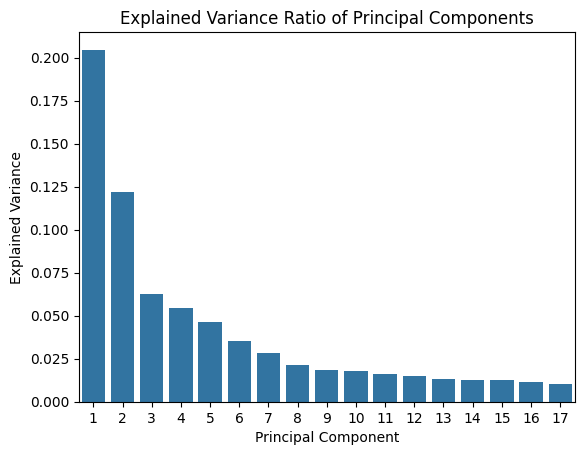

In [ ]:
# applying PCA
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_filtered)

# plotting explained variance ratio
sns.barplot(x=np.arange(1, n_components+1), y=pca_reduced.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [ ]:
# splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_filtered, test_size=0.2, random_state=42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
n_qubit = n_components

# defining quantum kernel
dev = qml.device('default.qubit', wires=n_qubit)
@qml.qnode(dev)
def kernel(x1, x2, n_qubit):
    qml.AngleEmbedding(x1, wires=range(n_qubit)) # encoding x1 into quantum state using AngleEmbedding
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubit))
    return qml.expval(qml.Projector([0]*n_qubit, wires=range(n_qubit))) # computing the expectation value of the projector

In [18]:
def kernel_mat(A, B, n_qubit):
    """
    Computes the kernel matrix for two sets of input data using a specified kernel function.

    Parameters:
    A (array-like): First set of input data.
    B (array-like): Second set of input data.
    n_qubit (int): Number of qubits used in the kernel function.

    Returns:
    np.ndarray: Kernel matrix computed from the input data.
    """
    mat = []
    
    # Iterate over each element in the first set of input data
    for a in A:
        row = []
        
        # Iterate over each element in the second set of input data
        for b in B:
            # Compute the kernel value for the pair (a, b) and append to the row
            row.append(kernel(a, b, n_qubit))
        
        # Append the row to the matrix
        mat.append(row)
    
    # Convert the list of lists to a numpy array and return
    return np.array(mat)

In [ ]:

size_QML = 5

idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

idx_0_sampled = np.random.choice(idx_0, size=size_QML, replace=False)
idx_1_sampled = np.random.choice(idx_1, size=size_QML, replace=False)

sampled_indices = np.concatenate([idx_0_sampled, idx_1_sampled])

X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

In [8]:
params = {
    'C': np.linspace(0.1, 10, 100), 
    'gamma': np.linspace(0.1, 10, 100), 
    'kernel': [kernel_mat], 
    'random_state': [42],
    'probability': [False],
}

svm_temp = RandomizedSearchCV(SVC(), param_distributions=params, n_iter=10, random_state=42)
svm_temp.fit(X_train_sampled, y_train_sampled)
best_params = svm_temp.best_params_
print(f'best params: {svm_temp.best_params_}')

best params: {'random_state': 42, 'probability': False, 'kernel': <function kernel_mat at 0x0000023B706E90D0>, 'gamma': 7.1, 'C': 7.3}


In [9]:
size_QML = 15

idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

idx_0_sampled = np.random.choice(idx_0, size=size_QML, replace=False)
idx_1_sampled = np.random.choice(idx_1, size=size_QML, replace=False)

sampled_indices = np.concatenate([idx_0_sampled, idx_1_sampled])

X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

In [10]:
svm_QML = SVC(**best_params)
svm_QML.fit(X_train_sampled, y_train_sampled)
y_pred_QML = svm_QML.predict(X_test)
accuracy_QML = accuracy_score(y_test, y_pred_QML)
print(f"Accuracy of QML SVM: {accuracy_QML}")

Accuracy of QML SVM: 0.5033288948069241


In [11]:
size = 15

idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

idx_0_sampled = np.random.choice(idx_0, size=size, replace=False)
idx_1_sampled = np.random.choice(idx_1, size=size, replace=False)

sampled_indices = np.concatenate([idx_0_sampled, idx_1_sampled])

X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]


svm = SVC()
svm.fit(X_train_sampled, y_train_sampled)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of SVM: {accuracy}")

Accuracy of SVM: 0.9760319573901465
